# Convolutional Autoencoder (CAE) + Lightweight NN Classifier
- data resized to 128x128
- CAE: MSE-SSIM loss, clf: Cross Entropy loss
- trained simultaneously, for 50 epochs
- saved in cae_ae_epoch_49.pth and cae_clf_epoch_49.pth, respectively
- evaluation and visualization included

In [1]:
# Import libraries
from torchmetrics import StructuralSimilarityIndexMeasure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support
from torch.utils.data import Subset

In [2]:
# Set random seed for reproducibility
SEED = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
# Dataset paths
train_dir = "../../linsen_data/train"
test_dir = "../../linsen_data/test"

# Extra preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),    # Resize the image to 128x128 for ligher computation
    transforms.ToTensor(),
])

# Load train data
train_dataset = datasets.ImageFolder(root='../../linsen_data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Number of images in train:", len(train_dataset))

# Filter for class 0 ("good") for CAE training
target_class = 0  
filtered_indices = [i for i, (_, label) in enumerate(train_dataset) if label == target_class]
cae_train_dataset = Subset(train_dataset, filtered_indices)
cae_train_loader = DataLoader(cae_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Number of images in train (class {target_class}):", len(cae_train_dataset))

# Load test data
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Number of images in train: 1404
Number of images in train (class 0): 750


In [4]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.encoder(x)

# Decoder Model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  # Output in range [0, 1]
        )
    
    def forward(self, x):
        return self.decoder(x)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Classifier Model
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder  # Pretrained encoder
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # Binary classification: Good/Bad
        )
    
    def forward(self, x):
        # with torch.no_grad():  # Freeze encoder during classification
        features = self.encoder(x)
        return self.fc(features)

# CAE setup
autoencoder = Autoencoder().to(DEVICE)
mse_loss_fn = nn.MSELoss()
ssim_loss_fn = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
def reconstruction_loss(output, target):
    output_normalized = (output + 1) / 2  # Normalize to [0, 1] for SSIM
    target_normalized = (target + 1) / 2  
    ssim_loss = 1 - ssim_loss_fn(output_normalized, target_normalized)  
    mse_loss = mse_loss_fn(output, target) 
    total_loss = 0.5 * ssim_loss + 0.5 * mse_loss
    return total_loss
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Classifier setup
classifier = Classifier(autoencoder.encoder).to(DEVICE)
classification_loss = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [5]:
# Checkpoint save function
def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, filename)


In [6]:
# For plotting later
train_reconstruction_losses = []
train_classification_accuracies = []
test_classification_accuracies = []

In [7]:
# Training loop
for epoch in range(EPOCHS):
    # CAE training
    autoencoder.train()
    train_reconstruction_loss = 0.0
    for inputs, _ in cae_train_loader:
        inputs = inputs.to(DEVICE)

        outputs = autoencoder(inputs)
        loss = reconstruction_loss(outputs, inputs)

        autoencoder_optimizer.zero_grad()
        loss.backward()
        autoencoder_optimizer.step()

        train_reconstruction_loss += loss.item() * inputs.size(0)

    train_reconstruction_loss /= len(cae_train_loader.dataset)
    train_reconstruction_losses.append(train_reconstruction_loss)  

    save_checkpoint(autoencoder, autoencoder_optimizer, epoch, f'cae_ae_epoch_{epoch}.pth')
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Reconstruction Loss: {train_reconstruction_loss:.4f}")

    # Classifier training
    classifier.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = classifier(inputs)
        loss = classification_loss(outputs, labels)

        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total
    train_classification_accuracies.append(train_accuracy)

    save_checkpoint(classifier, classifier_optimizer, epoch, f'cae_clf_epoch_{epoch}.pth')

    # Classifier evaluation
    classifier.eval()
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []
    incorrect_samples = []
    correct_samples = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = classifier(inputs)
            _, predicted = outputs.max(1)

            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            for i in range(len(inputs)):
                if predicted[i] == labels[i]:
                    correct_samples.append((inputs[i].cpu(), labels[i].item(), predicted[i].item()))
                else:
                    incorrect_samples.append((inputs[i].cpu(), labels[i].item(), predicted[i].item()))

    test_accuracy = test_correct / test_total
    test_classification_accuracies.append(test_accuracy)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f'Epoch {epoch + 1}/{EPOCHS} | Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f} ' \
          f'| Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')


Epoch 1/50, Train Reconstruction Loss: 0.3114
Epoch 1/50 | Train Acc: 0.6567 | Test Acc: 0.6280 | Precision: 0.7317 | Recall: 0.2679 | F1: 0.3922
Epoch 2/50, Train Reconstruction Loss: 0.3097
Epoch 2/50 | Train Acc: 0.6439 | Test Acc: 0.6240 | Precision: 0.8000 | Recall: 0.2143 | F1: 0.3380
Epoch 3/50, Train Reconstruction Loss: 0.2927
Epoch 3/50 | Train Acc: 0.6937 | Test Acc: 0.6360 | Precision: 0.7692 | Recall: 0.2679 | F1: 0.3974
Epoch 4/50, Train Reconstruction Loss: 0.2729
Epoch 4/50 | Train Acc: 0.6973 | Test Acc: 0.6440 | Precision: 0.8286 | Recall: 0.2589 | F1: 0.3946
Epoch 5/50, Train Reconstruction Loss: 0.2603
Epoch 5/50 | Train Acc: 0.7137 | Test Acc: 0.6920 | Precision: 0.8070 | Recall: 0.4107 | F1: 0.5444
Epoch 6/50, Train Reconstruction Loss: 0.2483
Epoch 6/50 | Train Acc: 0.7030 | Test Acc: 0.6680 | Precision: 0.8222 | Recall: 0.3304 | F1: 0.4713
Epoch 7/50, Train Reconstruction Loss: 0.2416
Epoch 7/50 | Train Acc: 0.6966 | Test Acc: 0.6320 | Precision: 0.8125 | Recall

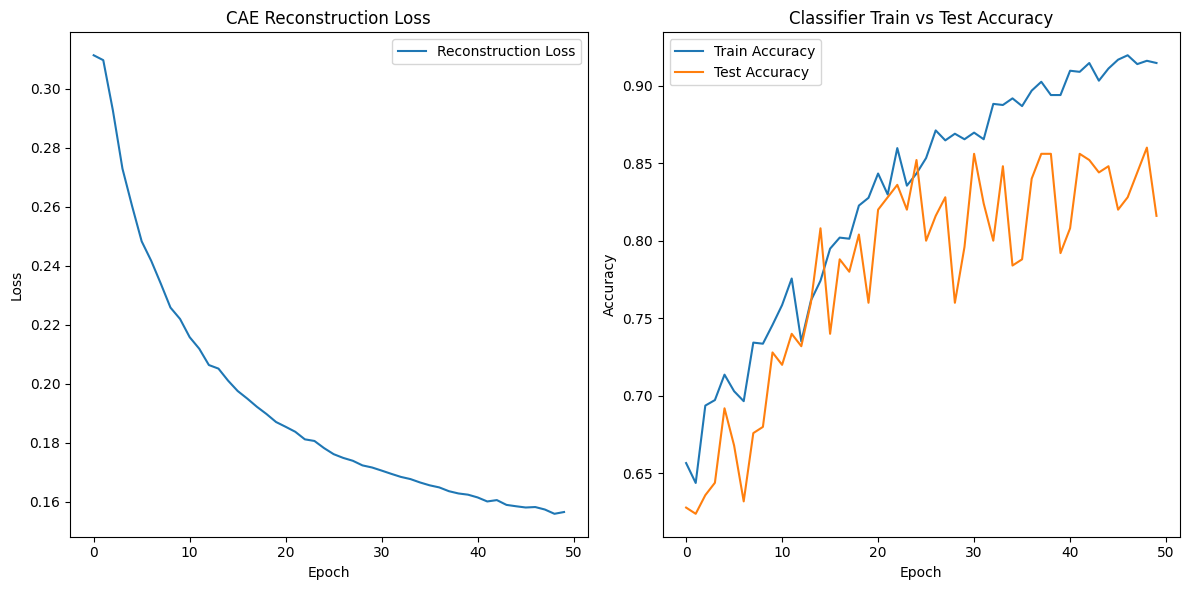

In [8]:
# Plotting results
plt.figure(figsize=(12, 6))

# Plot reconstruction accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), train_reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CAE Reconstruction Loss')
plt.legend()

# Plot classification accuracy
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), train_classification_accuracies, label='Train Accuracy')
plt.plot(range(EPOCHS), test_classification_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier Train vs Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
import random

# Plot original, reconstruction, error heatmap, true and predicted label for a random image
def test_model_on_image(autoencoder, classifier, test_loader, device=DEVICE):

    autoencoder.eval()
    classifier.eval()

    inputs, labels = next(iter(test_loader))
    idx = random.randint(0, len(inputs) - 1)

    img = inputs[idx].unsqueeze(0).to(device)
    true_label = labels[idx].item()

    with torch.no_grad():
        reconstruction = autoencoder(img).squeeze(0).cpu()
        reconstruction_error = torch.abs(img.squeeze(0).cpu() - reconstruction)

        outputs = classifier(img)
        _, predicted_label = outputs.max(1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.title(f"Original Image (True: {true_label})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(reconstruction.permute(1, 2, 0).numpy())
    plt.title(f"Reconstructed Image (Pred: {predicted_label.item()})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(reconstruction_error.permute(1, 2, 0).numpy(), cmap="hot")
    plt.title("Reconstruction Error")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


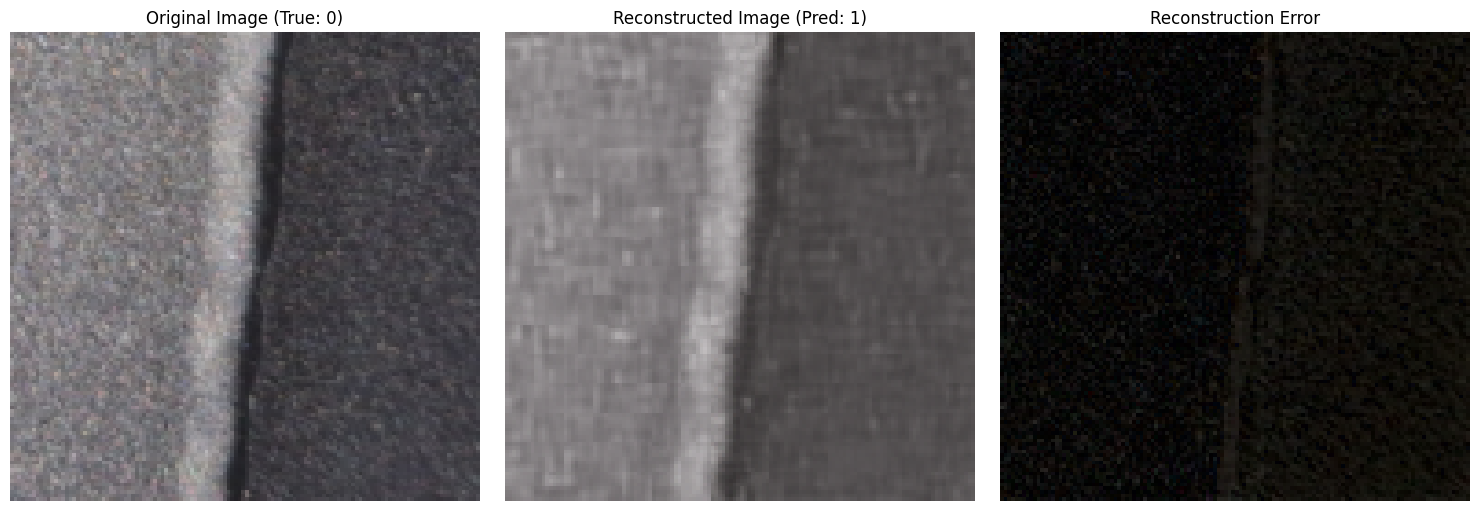

In [12]:
test_model_on_image(autoencoder, classifier, test_loader)

Visualizing training data:


/var/folders/8_/f8kmzr5j715637z3t60_pjqm0000gn/T/ipykernel_23601/2511605054.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


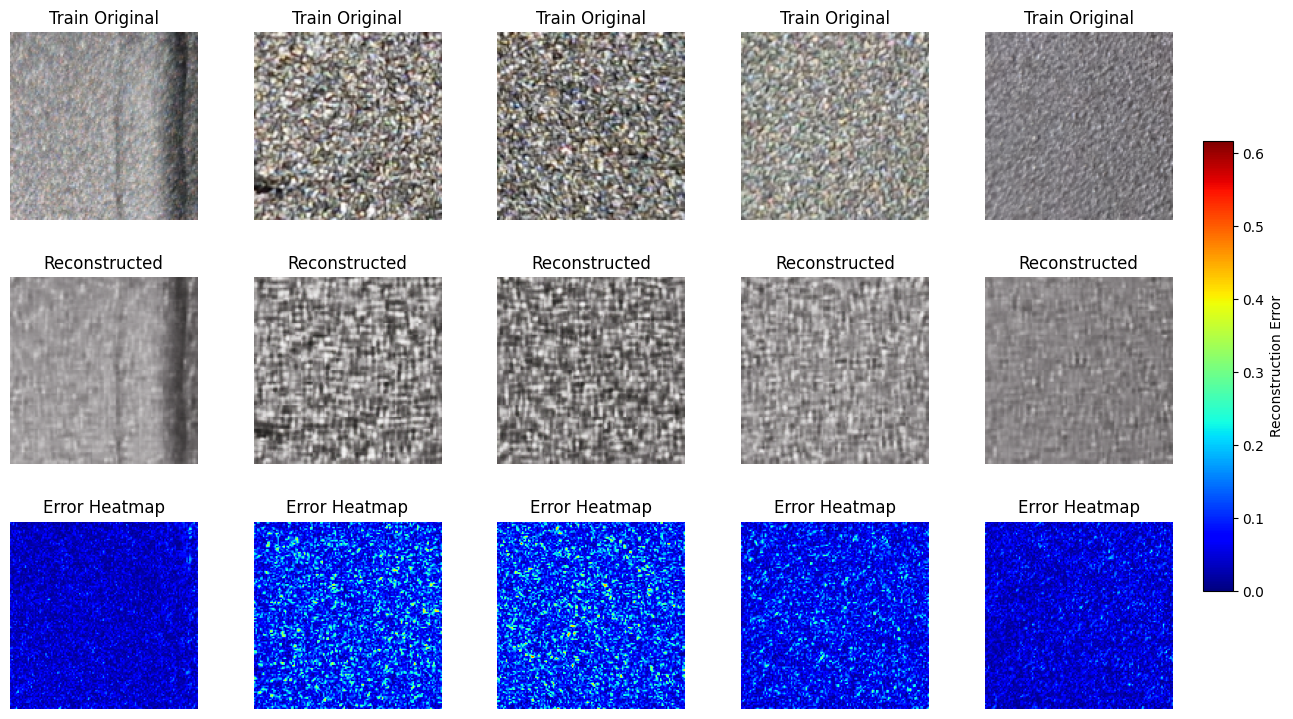

Visualizing good test data:


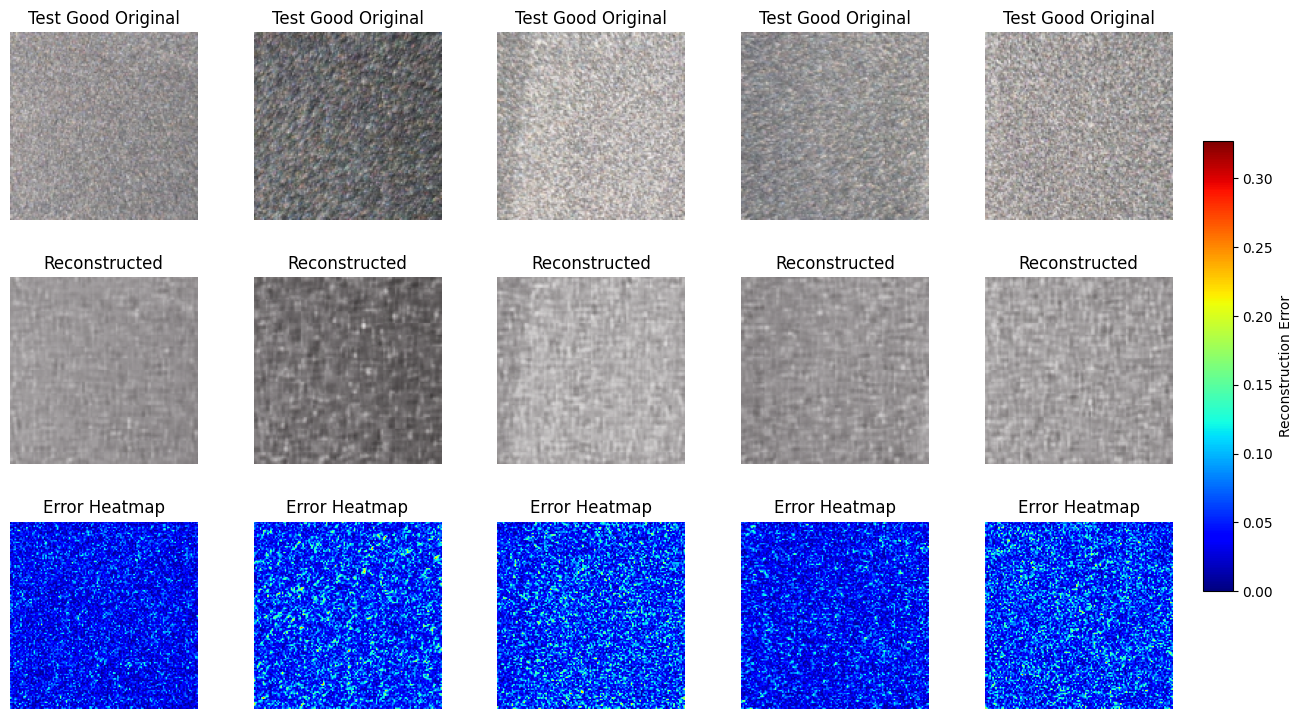

Visualizing bad test data:


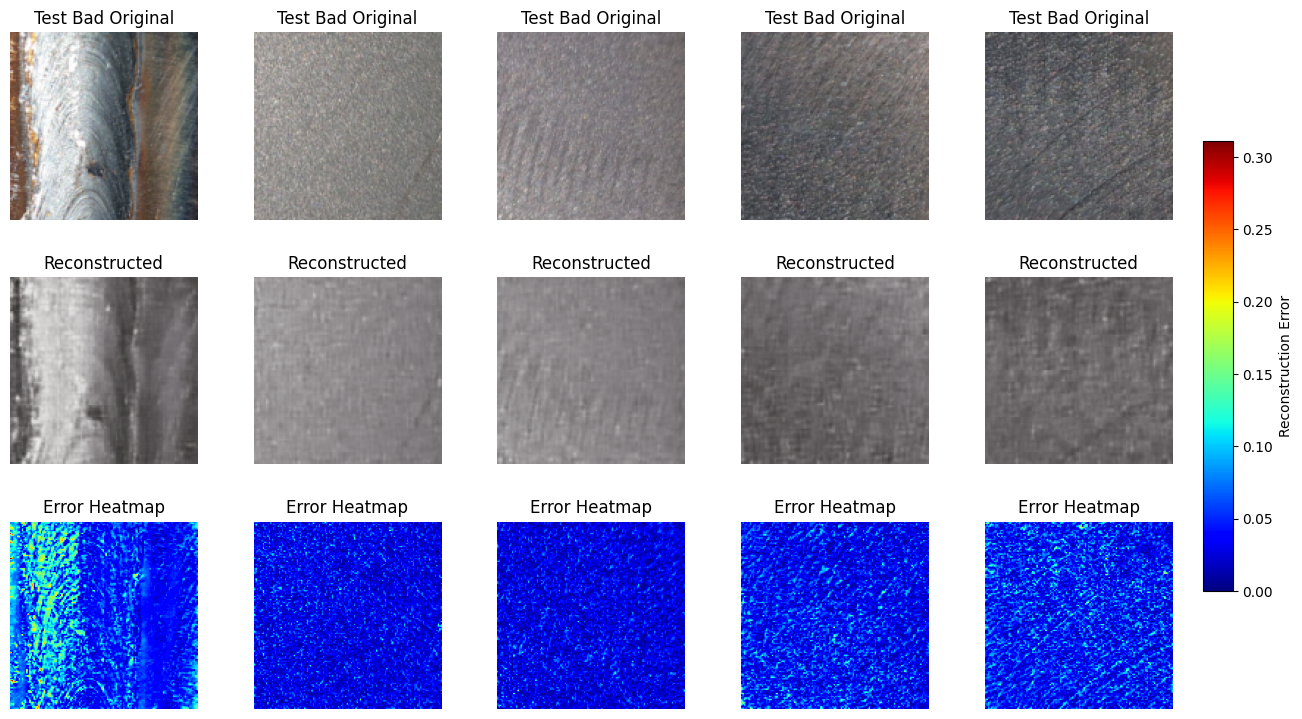

In [20]:
# Plot original, reconstruction, error heatmap for random good images from dataloader
def visualize_autoencoder_performance(autoencoder, data_loader, num_samples=5, title_prefix=""):
    autoencoder.eval() 
    images, labels = next(iter(data_loader))  
    selected_indices = random.sample(range(len(images)), num_samples)  
    images = images[selected_indices].to(DEVICE)  
    
    with torch.no_grad():
        reconstructions = autoencoder(images)  
        errors = torch.abs(images - reconstructions)  

    images_np = images.cpu().permute(0, 2, 3, 1).numpy()  
    reconstructions_np = reconstructions.cpu().permute(0, 2, 3, 1).numpy()
    errors_np = errors.cpu().permute(0, 2, 3, 1).numpy()

    max_error = errors_np.mean(axis=-1).max()  

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9), gridspec_kw={'width_ratios': [1]*num_samples, 'wspace': 0.3})

    for i in range(num_samples):
        axes[0, i].imshow(images_np[i])  
        axes[0, i].set_title(f"{title_prefix} Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructions_np[i])  
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

        im = axes[2, i].imshow(errors_np[i].mean(axis=-1), cmap="jet", vmin=0, vmax=max_error)
        axes[2, i].set_title("Error Heatmap")
        axes[2, i].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  
    fig.colorbar(im, cax=cbar_ax, label="Reconstruction Error")
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  
    plt.show()

print("Visualizing training data:")
visualize_autoencoder_performance(autoencoder, cae_train_loader, num_samples=5, title_prefix="Train")

print("Visualizing good test data:")
visualize_autoencoder_performance(autoencoder, test_loader, num_samples=5, title_prefix="Test Good")

print("Visualizing bad test data:")
test_bad_loader = DataLoader(
    Subset(test_dataset, [i for i, (_, label) in enumerate(test_dataset) if label != target_class]),
    batch_size=BATCH_SIZE,
    shuffle=False
)
visualize_autoencoder_performance(autoencoder, test_bad_loader, num_samples=5, title_prefix="Test Bad")


/var/folders/8_/f8kmzr5j715637z3t60_pjqm0000gn/T/ipykernel_23601/2511605054.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


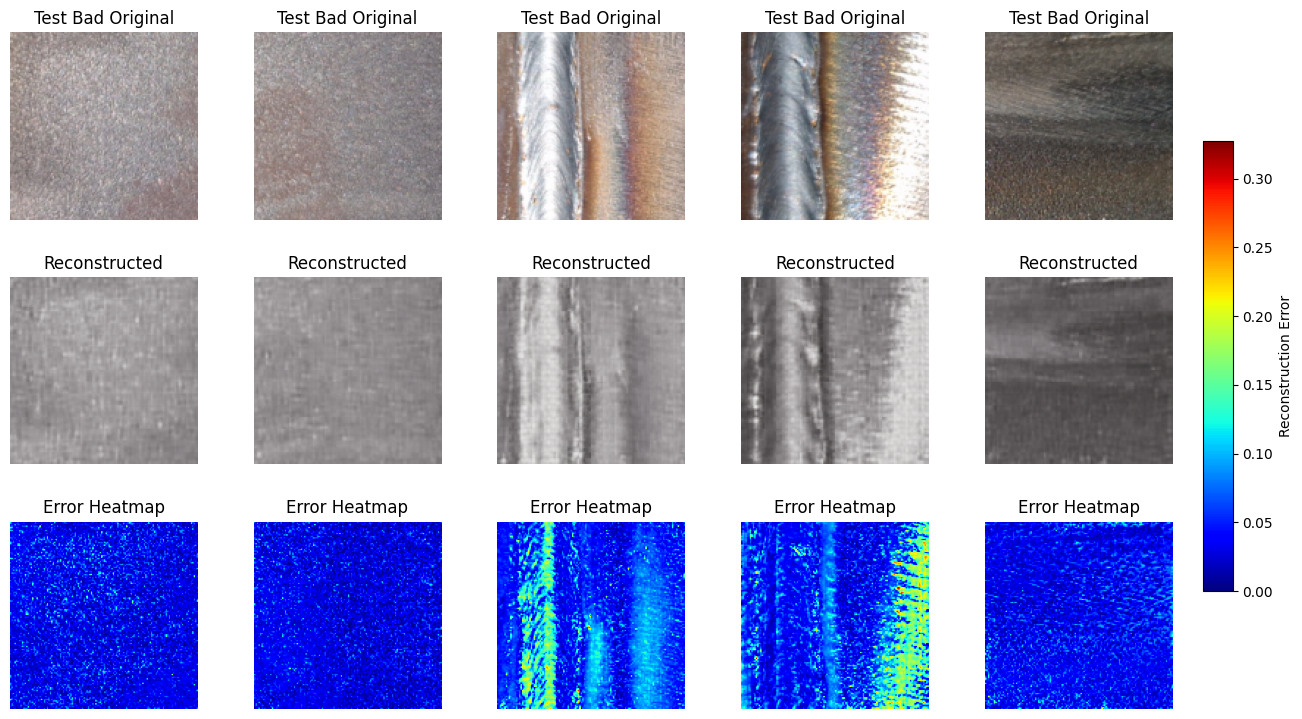

In [39]:
visualize_autoencoder_performance(autoencoder, test_bad_loader, num_samples=5, title_prefix="Test Bad")

In [15]:
# Plot original, reconstruction, error heatmap, true and predicted label for 5 images from list
def plot_heatmaps(samples, title):
    plt.figure(figsize=(15, 10))
    for i, (img, true_label, pred_label) in enumerate(samples[:5]):
        img = img.unsqueeze(0).to(DEVICE)

        reconstruction = autoencoder(img).squeeze(0).cpu().detach()
        reconstruction_error = torch.abs(img.squeeze(0).cpu() - reconstruction)

        plt.subplot(5, 3, i * 3 + 1)
        plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy())
        plt.title(f"Original (True: {true_label})")
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 2)
        plt.imshow(reconstruction.permute(1, 2, 0).numpy())
        plt.title(f"Reconstructed (Pred: {pred_label})")
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 3)
        plt.imshow(reconstruction_error.permute(1, 2, 0).numpy(), cmap='jet')
        plt.title("Reconstruction Error")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


Correctly Classified Samples:


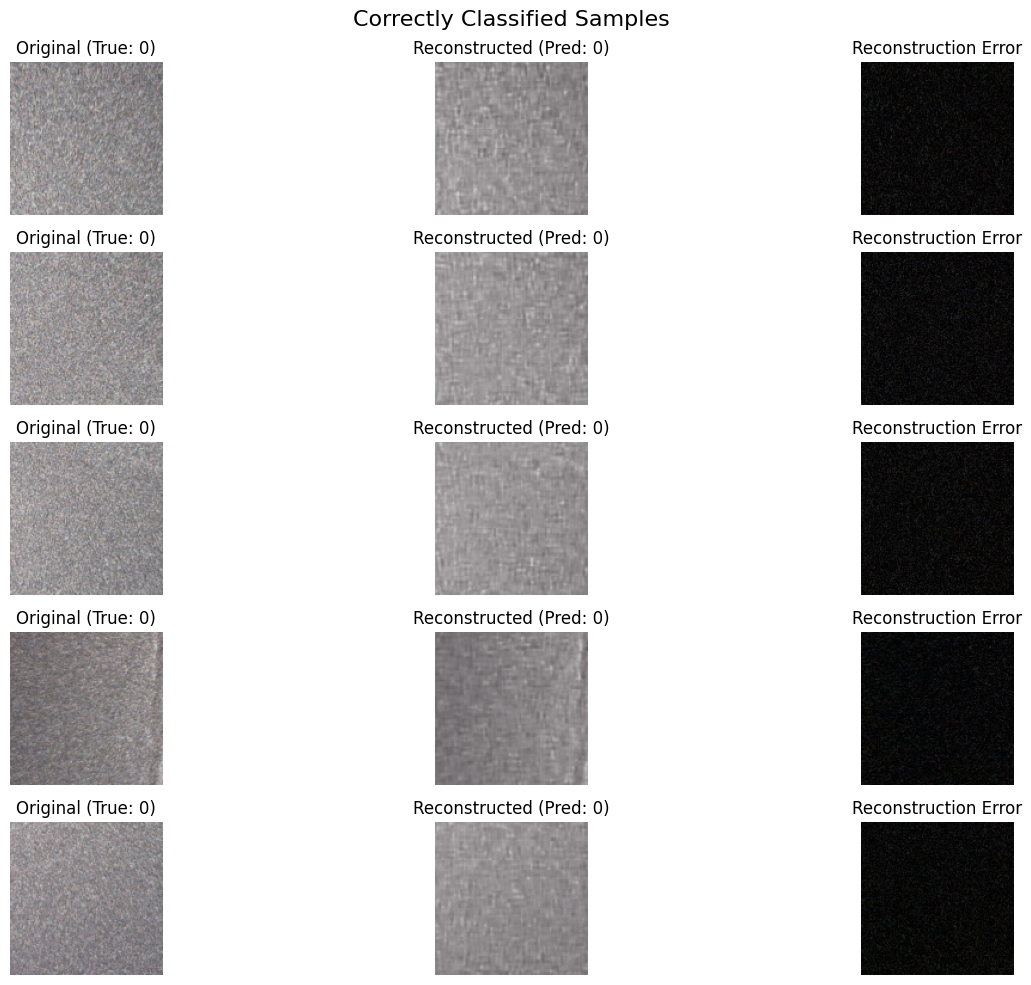

Incorrectly Classified Samples:


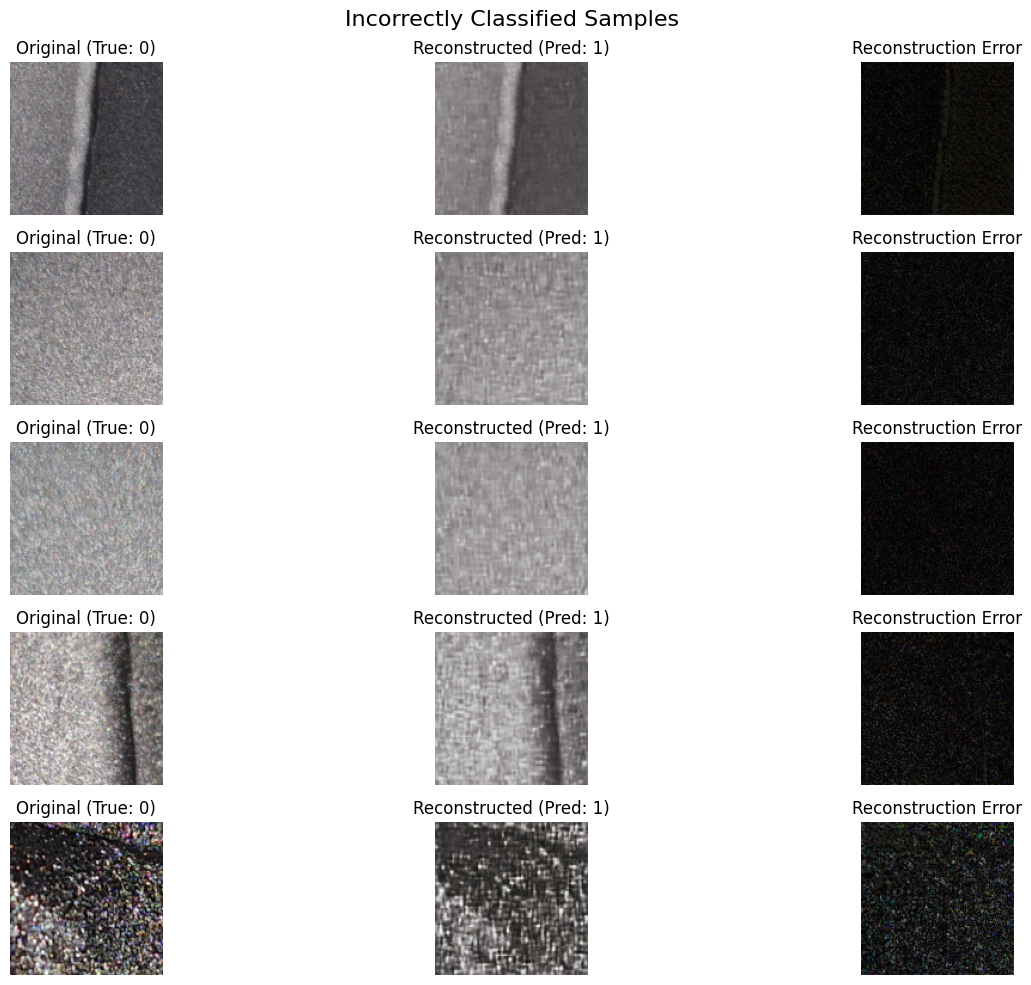

In [16]:
print("Correctly Classified Samples:")
plot_heatmaps(correct_samples, title="Correctly Classified Samples")

print("Incorrectly Classified Samples:")
plot_heatmaps(incorrect_samples, title="Incorrectly Classified Samples")


In [ ]:
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

import seaborn as sns
import pandas as pd

In [18]:
# Compute evaluation metrics on test set
def evaluate_test_set(test_loader, classifier):
    y_true = []
    y_pred = []

    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            logits = classifier(inputs)
            predictions = logits.argmax(dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
    accuracy = accuracy_score(y_true, y_pred)
    
    results = pd.DataFrame({
        "Category": ["Ready for Paint", "Needs Shot Blasting"],
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })
    results.loc["Accuracy"] = ["", "", "", accuracy]  
    print(results)
    return results


evaluate_test_set(test_loader, classifier)


                     Category Precision    Recall  F1-Score
0             Ready for Paint  0.770588  0.949275  0.850649
1         Needs Shot Blasting    0.9125  0.651786  0.760417
Accuracy                                           0.816000


Category Precision    Recall  F1-Score
0             Ready for Paint  0.770588  0.949275  0.850649
1         Needs Shot Blasting    0.9125  0.651786  0.760417
Accuracy                                           0.816000

In [87]:
# Plot original, reconstruction, error heatmap, true and predicted label for all images from list
def plot_all_heatmaps(samples, title):
    num_samples = len(samples)
    plt.figure(figsize=(15, 3 * num_samples))  

    for i, (img, true_label, pred_label) in enumerate(samples):
        img = img.unsqueeze(0).to(DEVICE)

        reconstruction = autoencoder(img).squeeze(0).cpu().detach()
        reconstruction_error = torch.abs(img.squeeze(0).cpu() - reconstruction)

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy())
        plt.title(f"Original (True: {true_label})")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(reconstruction.permute(1, 2, 0).numpy())
        plt.title(f"Reconstructed (Pred: {pred_label})")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(reconstruction_error.permute(1, 2, 0).numpy(), cmap='jet')
        plt.title("Reconstruction Error")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
print("Correctly Classified Samples:")
plot_all_heatmaps(correct_samples, title="Correctly Classified Samples")

print("Incorrectly Classified Samples:")
plot_all_heatmaps(incorrect_samples, title="Incorrectly Classified Samples")

In [ ]:
# To load a saved model
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from {checkpoint_path}")

In [19]:
# Load the saved autoencoder and classifier models

# autoencoder_checkpoint_path = "cae_ae_epoch_49.pth"
# classifier_checkpoint_path = "cae_clf_epoch_49.pth"

# eval_cae = Autoencoder().to(DEVICE)
# eval_clf = Classifier(eval_cae.encoder).to(DEVICE)

# load_checkpoint(eval_cae, autoencoder_checkpoint_path)
# load_checkpoint(eval_clf, classifier_checkpoint_path)

